In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_train import evaluate_classification_model as evaluate_model


# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(train_dataset[0])
train_dataset[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x25ADF640E60>, 9)


# 加载数据并处理为tensor

In [2]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称
class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")

print(train_images[0])

train_labels[0:20]

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=int64)

In [3]:
def calculate_mean_std(train_dataset):
    # 首先将所有图像堆叠为一个大张量
    all_images=torch.stack([image_tensor for image_tensor,_ in train_dataset])
    print(all_images.shape)
    # 计算通道维度上的均值和标准差
    # Fashion MNIST 是灰度图像，只有一个通道
    # 对所有像素值计算均值和标准差
    mean=torch.mean(all_images)
    std=torch.std(all_images)
    print(f"训练数据集均值: {mean.item():.4f}")
    print(f"训练数据集标准差: {std.item():.4f}")

    # 检查数据集大小
    print(f"数据集中图像总数: {len(train_dataset)}")

# calculate_mean_std(train_dataset)

In [4]:
train_dataset[0][0].squeeze().shape

torch.Size([28, 28])

# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [5]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")

训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


# 搭建模型

In [6]:
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=3, dropout_rate=0.3, initial_size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # 使用BatchNorm提高模型稳定性和训练速度
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, initial_size),
            nn.BatchNorm1d(initial_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
        )
        
        # 构建漏斗形网络结构，逐层减小神经元数量
        current_size = initial_size
        for i in range(1, layers_num):
            next_size = current_size // 2  # 每层减半
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(current_size, next_size))
            self.linear_relu_stack.add_module(f"BatchNorm_{i}", nn.BatchNorm1d(next_size))
            self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
            self.linear_relu_stack.add_module(f"dropout_{i}", nn.Dropout(p=dropout_rate))
            current_size = next_size
            
        # 输出层使用较小的dropout
        self.linear_relu_stack.add_module("Output_dropout", nn.Dropout(p=0.1))
        self.linear_relu_stack.add_module("Output_Layer", nn.Linear(current_size, 10))
        
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 使用kaiming初始化，更适合ReLU激活函数
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # 使用小的正数初始化偏置，避免dead ReLU
                nn.init.constant_(m.bias, 0.01)
                
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits

In [8]:
# 实例化模型
model=NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter=iter(train_loader) # iter()方法返回一个迭代器对象
images,labels=next(dataiter) # next()方法返回迭代器的下一个项目

# 查看批次数据的形状
print("批次图像形状:",images.shape)
print("批次标签形状:",labels.shape)

# 选择第一张图像进行前向传播测试,unsqueeze(0)是添加批次维度
test_image = images[0].unsqueeze(0)  # 添加批次维度
print("测试图像形状:", test_image.shape)

print('-'*100)

with torch.no_grad(): # 禁用梯度计算
    outputs=model(images)
    print("模型输出的形状:", outputs.shape)

# 获取预测结果
_, predicted = torch.max(outputs, 1) 
print("预测结果形状:", predicted.shape)
# torch.max()返回的是一个tuple，第一个元素是最大值，第二个元素是最大值的索引,
# 第二个参数表示取最大值的方向
print("模型预测结果:", predicted[0].item())
print("实际标签:", labels[0].item())

批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
测试图像形状: torch.Size([1, 1, 28, 28])
----------------------------------------------------------------------------------------------------
模型输出的形状: torch.Size([64, 10])
预测结果形状: torch.Size([64])
模型预测结果: 0
实际标签: 4


In [9]:
# 计算模型的总参数量
total_params = sum(p.numel() for p in model.parameters()) # numel() 返回元素数量
print(f"模型总参数量: {total_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

模型总参数量: 569226

各层参数量明细:
linear_relu_stack.0.weight: 401408 参数
linear_relu_stack.0.bias: 512 参数
linear_relu_stack.1.weight: 512 参数
linear_relu_stack.1.bias: 512 参数
linear_relu_stack.Linear_1.weight: 131072 参数
linear_relu_stack.Linear_1.bias: 256 参数
linear_relu_stack.BatchNorm_1.weight: 256 参数
linear_relu_stack.BatchNorm_1.bias: 256 参数
linear_relu_stack.Linear_2.weight: 32768 参数
linear_relu_stack.Linear_2.bias: 128 参数
linear_relu_stack.BatchNorm_2.weight: 128 参数
linear_relu_stack.BatchNorm_2.bias: 128 参数
linear_relu_stack.Output_Layer.weight: 1280 参数
linear_relu_stack.Output_Layer.bias: 10 参数


In [10]:
model.state_dict() # 获取模型参数

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0689, -0.1150,  0.0815,  ..., -0.0191, -0.0388,  0.0728],
                      [ 0.0398, -0.0797, -0.0038,  ...,  0.1411,  0.0053,  0.0623],
                      [ 0.0106, -0.0722,  0.0527,  ...,  0.0825, -0.1554,  0.0220],
                      ...,
                      [ 0.0038, -0.0429, -0.0645,  ..., -0.0503, -0.0414,  0.1806],
                      [-0.0362,  0.0727,  0.0980,  ...,  0.1113,  0.0047, -0.0307],
                      [-0.0130,  0.0396, -0.0837,  ...,  0.1030,  0.1404,  0.0916]])),
             ('linear_relu_stack.0.bias',
              tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
                      0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
                      0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
                      0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
    

In [11]:
from torch.utils.tensorboard import SummaryWriter
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录
    """
    def __init__(self,log_dir='tensorboard_log'):
        import os
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)
        
        self.writer=SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘

    def log_training(self,epoch,train_loss,train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        self.writer.add_scalar('train_loss',train_loss,epoch)
        self.writer.add_scalar('train_acc',train_acc,epoch)
    
    def log_validation(self,epoch,val_loss,val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        self.writer.add_scalar('val_loss',val_loss,epoch)
        self.writer.add_scalar('val_acc',val_acc,epoch)
    
    def log_lr(self,epoch,lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        self.writer.add_scalar('lr',lr,epoch)
    
    def log_model_graph(self,model,images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """ 
        self.writer.add_graph(model,images)
    
    def closs(self):
        """
        关闭Tensorboard写入器
        """
        self.writer.close()

# 设置交叉熵损失函数，SGD优化器

In [12]:
model=NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss() # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9) # SGD优化器，学习率为0.01，动量为0.9
print("损失函数:",loss_fn)
print("优化器:",optimizer)

损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [13]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =NeuralNetwork(dropout_rate=0.3, initial_size=512)
model.to(device)
optimizer=torch.optim.Adam(model.parameters())

In [14]:

# device='cpu'
print(f"当前设备: {device}")
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)
tensorboard_logger=TensorboardLogger(log_dir='logs')

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=tensorboard_logger)


当前设备: cuda:0
训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 88.8200
早停: 已有5轮验证损失没有改善！


In [15]:
history['val'][-1000:-1]

[{'loss': 16.899724095153807, 'acc': 10.7, 'step': 0},
 {'loss': 0.48546032328605654, 'acc': 83.36, 'step': 500},
 {'loss': 0.4308036099910736, 'acc': 84.14, 'step': 1000},
 {'loss': 0.38646918687820436, 'acc': 86.06, 'step': 1500},
 {'loss': 0.3876049201965332, 'acc': 86.36, 'step': 2000},
 {'loss': 0.37634023184776305, 'acc': 85.94, 'step': 2500},
 {'loss': 0.36797951455116273, 'acc': 86.72, 'step': 3000},
 {'loss': 0.3573906052350998, 'acc': 87.02, 'step': 3500},
 {'loss': 0.35182093331813813, 'acc': 87.3, 'step': 4000},
 {'loss': 0.34468238751888275, 'acc': 87.72, 'step': 4500},
 {'loss': 0.3457391823887825, 'acc': 87.56, 'step': 5000},
 {'loss': 0.33512009100914003, 'acc': 88.12, 'step': 5500},
 {'loss': 0.32471050559282305, 'acc': 88.24, 'step': 6000},
 {'loss': 0.3493187413454056, 'acc': 87.44, 'step': 6500},
 {'loss': 0.3209104345560074, 'acc': 88.34, 'step': 7000},
 {'loss': 0.31459654475450516, 'acc': 88.82, 'step': 7500},
 {'loss': 0.32045904378890994, 'acc': 88.24, 'step': 

# 绘制损失曲线和准确率曲线

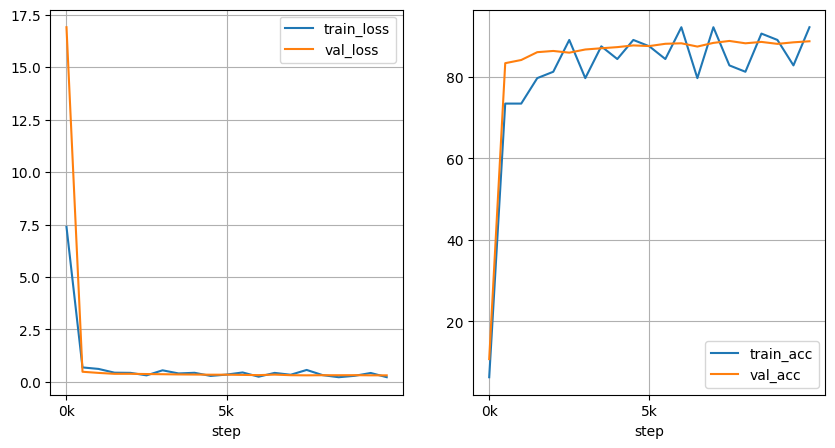

In [16]:
plot_learning_curves(history,sample_step=500)

In [17]:
test_accuracy=evaluate_model(model,test_loader,device,loss_fn)
test_accuracy

(88.87, 0.31062227255105973)